# Task 1: Simulate the dynamics of cat qubits at the effective Hamiltonian level.

In Tutorial 1, we have introduced that we can dissipatively stabilize a cat qubit by coupling a memory mode  that will store our cat qubit to a lossy buffer mode with a specific interaction that exchanges two photons of the memory mode with one photon in the buffer mode.

For this, consider the Lindblad master equation:

$$\frac{d \hat{\rho}}{dt} = \mathcal{L}[\hat{\rho}] = -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}]$$

The Hamiltonian of the system is given by
$$\hat{H} = \hat{H}_{\mathrm{2ph}} + \hat{H}_d, \qquad \mathrm{with}$$
$$\hat{H}_{\mathrm{2ph}} = g_2 {\hat{a}^\dagger}^2 \hat{b} + g_2^*\hat{a}^2 \hat{b}^\dagger$$
$$\hat{H}_d = \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger$$

Here, $\hat{H}_{\mathrm{2ph}}$ is the two-photon exchange Hamiltonian and $\hat{H}_d$ is the buffer drive Hamiltonian.

In [6]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import numpy as np

**Task 1.1: Getting started with `dynamiqs`**

Using `dynamiqs`, simulate the time-evolution of this system with the following parameters:

$$g_2=1.0~~~\epsilon_d=-4~~~\kappa_b=10$$

(For now, we pretend that the parameters are without dimensions)

Use an initial state $\lvert \psi_0 \rangle$ in which both the buffer and the memory are in the vacuum. Use a Hilbert-space truncation of $n_a = 20$ and $n_b = 5$ (number of Fock-states in mode a and mode b, respectively) to begin with. You can play with a different Hilbert-space truncation.

Simulate the dynamics for a time $T=4$. 

Plot the wigner function of mode a (as a GIF or as a mosaic plot).

Also plot the expectation value of the number of photons, as well as the photon number parity in the memory mode.


In [98]:
na = 20 # mode a
nb = 5 # mode b

g_2 = 1.0 + 0.0j
epsilon_d = -4+0.0j
kappa_b = 10

a = dq.destroy(na) # annihilaiton operator
b = dq.destroy(nb) # annihilaiton operator
psi0_a = dq.fock(na, 0) # initial state
psi0_b = dq.fock(nb, 0) # initial state
psi0_ab = dq.tensor(psi0_a, psi0_b) # initial state

a_upgraded = dq.tensor(a, dq.eye(nb))
b_upgraded = dq.tensor(dq.eye(na), b)

H_absorption = g_2 * (a_upgraded.dag() @ a_upgraded.dag() @ b_upgraded) + g_2.conjugate() * (a_upgraded @ a_upgraded @ b_upgraded.dag()) 
H_bdrive = epsilon_d.conjugate() * b_upgraded + epsilon_d * b_upgraded.dag() 
H = H_absorption + H_bdrive

tsave = np.linspace(0, 10, 100)
lossy_res = dq.mesolve(H, [kappa_b * b_upgraded], psi0_ab, tsave)



|          |   0.1% ◆ elapsed 4.08ms ◆ remaining 0.00ms

In [99]:
lossy_res_states_mode_a = dq.ptrace(lossy_res.states, keep=0)
gif_file = dq.plot.wigner_gif(lossy_res_states_mode_a) 


|██████████| 100.0% ◆ elapsed 4.15s ◆ remaining 0.00ms  

100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


/home/jovyan/.qbraid/environments/alice_g9lq38/pyenv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jovyan/.qbraid/environments/alice_g9lq38/pyenv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


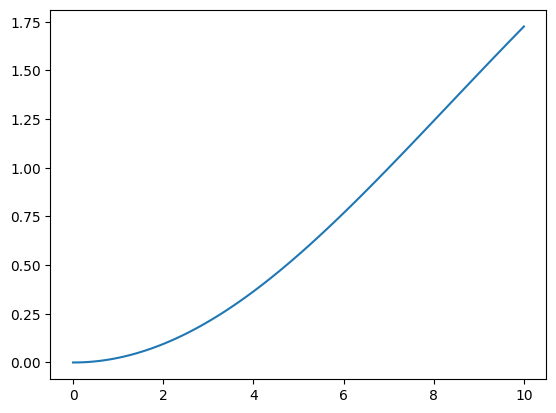

In [100]:
N_a_upgraded = a_upgraded.dag() @ a_upgraded
photon_numbers = [dq.expect(N_a_upgraded, state) for state in lossy_res.states]
plt.plot(tsave, photon_numbers)

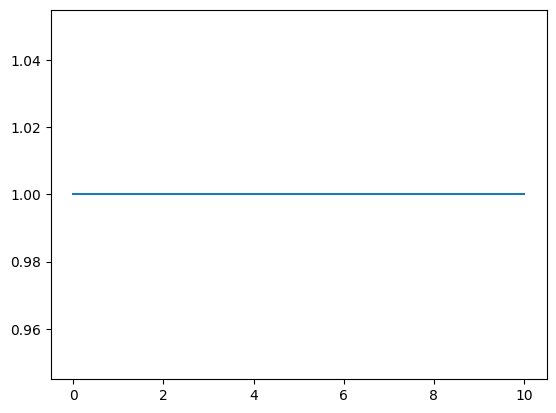

In [101]:
parity_op = dq.tensor(dq.parity(na), dq.eye(nb))
parities = [round(dq.expect(parity_op, state).item().real, 2) for state in lossy_res.states] 
plt.plot(tsave, parities)

**Task 1.2: Comparison with eliminated buffer mode**

Compare your result from Task 1.1 to the system where the buffer mode is adiabatically eliminated, in which the dynamics of the memory mode is given by:

$$\frac{d \hat{\rho}_a}{d t} = \kappa_2 \mathcal{D}[\hat{a}^2 - \alpha^2](\hat{\rho}_a)$$

with two-photon dissipation rate $\kappa_2 = 4|g_2|^2 / \kappa_b$ and cat amplitude $\alpha^2 = -\epsilon_d/g_2^*$.

Compute the time-evolution of the fidelity between the time-evolved states computed with the two-mode system from Task 1.1. What do you observe if you lower $\kappa_b$?

|          |   0.1% ◆ elapsed 0.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 38.07ms ◆ remaining 0.00ms

100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


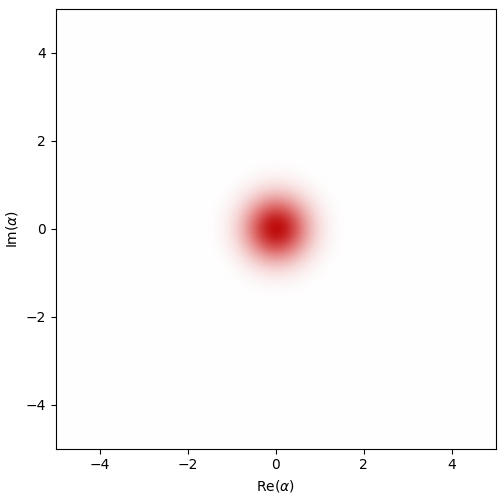

In [102]:
# get tutorial 1 states
H0 = dq.zeros(na) # zero Hamiltonian

kappa_2 = 4*g_2*g_2.conjugate()/kappa_b # two-photon loss rate
alpha_sq = -epsilon_d/g_2.conjugate() # cat size

loss_op = kappa_2*(a @ a - alpha_sq * dq.eye(na)) # loss operator
elim_res = dq.mesolve(H0, [loss_op], psi0_a, tsave)
dq.plot.wigner_gif(elim_res.states)

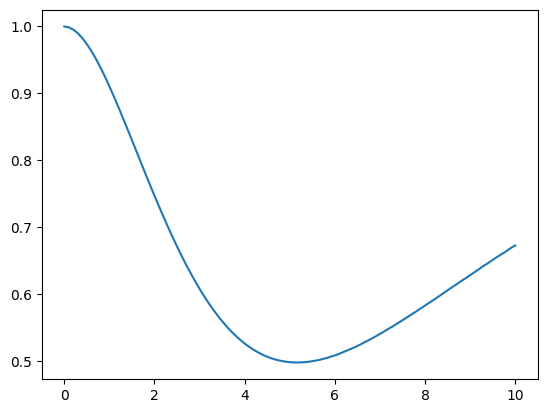

In [103]:
fidelities = dq.fidelity(res_states_mode_a, elim_res.states) 
plt.plot(tsave, fidelities)

**Task 1.3: Performing a Zeno-gate**

To fully control a cat qubit, we also need to be able to perform gates.

**$Z(\theta)$-rotation**: In addition to the dissipative stabilization mechanism simulated in Task 1.1, find a Hamiltonian that performs a contiuous rotation around the $Z$-axis of the qubit, also called Zeno gate, (as a reminder: the cat states $\lvert \mathcal{C}_\alpha^ \pm \rangle$ define the logical $X$-eigenstates $\lvert\pm\rangle$). This additional Hamiltonian has the form: $\hat{H}_Z = \epsilon_Z^* \hat{O} + \epsilon_Z \hat{O}^\dagger$, where $\hat{O}$ is a bosonic operator.

**a)** Simulate the time-evolution that maps $\lvert+\rangle$ to $\lvert-\rangle$ in a time $T_Z$, where $2T_Z$ is the time it takes to make a full rotation.
The speed of rotation will depend on the strenght of the parameter $\epsilon_Z$ in the Hamiltonian $H_Z$ that generates the rotation.

**b)** Optimize parameters: In a real-world scenario, also our memory mode is subject to losses of single photons. Let $\kappa_a$ be the single-photon loss rate of mode a.

For various values of $\kappa_a$ from the interval $\kappa_a \in [0.01, 2]$ and for various values of $\epsilon_Z$, plot the parity as a function of time in the presence of $\hat{H}_Z$.

For the parameter range of $\kappa_a$ above, find the optimal times $T_Z$ for a rotation of $\theta = 0 \rightarrow \pi.$

**Task 1.4: Optimal control for state-preparation**

In Task 1.1, we assumed that the parameter $\epsilon_d$ in $\hat{H}_d$ is constant throughout the time evolution. Now, you will simulate what happens if we let $\epsilon_d$ depend on time.

We would like to answer the question: What is the optimal function of time of $\epsilon_d(t)$ to inflate a cat from the vacuum to a target value of $\alpha^2 = 4$ in a given time $T =3$?

For this, first find and define an adequate loss function.
Then, optimize over $\epsilon_d(t)$. For this, you can assume that $\hat{H}_d$ is piecewise constant. You can play with the number of bins in $\hat{H}_d$.
Plot the optimized value of $\epsilon_d(t)$ as a function of time.
What happens if you increase or decrease $T$?
